# Generation of data

#### Distribution
On peut utiliser des données i.i.d. :
- [x] Student-t
- [x] type 2 (=Frechet) extreme value distribution
- [ ] generalized extreme value distribution (pas dans l'article)

On peut utiliser des données dépendantes :
- [ ] MA(1) process avec des variables cachées de Student-t
- [ ] Stochastic processes

On peut utiliser des données réelles
- [ ] Données financières

#### Nombre d'échantillons
2_000 à 20_000 échantillons


In [1]:
import numpy as np
from scipy.stats import t, invweibull, genextreme
import matplotlib.pyplot as plt
import json


### Simulation variables de Student

# df = 10
# r = t.rvs(df, size=10000)
# plt.hist(r, density=True, bins=100, log=False)

# fig, ax = plt.subplots(1, 1)
# mean, var, skew, kurt = t.stats(df, moments='mvsk')
# x = np.linspace(t.ppf(0.01, df),
#                 t.ppf(0.99, df), 100)
# ax.plot(x, t.pdf(x, df),
#        'r-', lw=5, alpha=0.6, label='t pdf')

# rv = t(df)
# ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

# vals = t.ppf([0.001, 0.5, 0.999], df)
# np.allclose([0.001, 0.5, 0.999], t.cdf(vals, df))

# ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
# ax.legend(loc='best', frameon=False)
# plt.show()

def get_student_sample(degrees_freedom, size_sample, get_plot=False, log_plot=False, nb_bins=100):
    # Le nombre de degrés de liberté correspond au nombre de paramètres
    # Si degrees_freedom < 1 : pas d'espérance
    r = t.rvs(degrees_freedom, size=size_sample)
    if get_plot:
        plt.hist(r, density=True, bins=nb_bins, log=log_plot, label="student_samples", alpha = 0.8)
        plt.legend()
    return r


### Simulation type II EVD (Frechet distribution)


def get_frechet_sample(inv_gamma, size_sample, get_plot=False, log_plot=False, nb_bins=100):
    # Warning : takes in input inverse of gamma (gamma being the tail index)
    # The smaller inv_gamma, the heavier the tail
    sample = invweibull.rvs(inv_gamma, size=size_sample)
    if get_plot:
        plt.hist(sample, density=True, bins=nb_bins, log=log_plot, label="frechet_samples", alpha = 0.6)
        plt.legend()
    return sample


# # Trouver la relation entre X suit frechet et Y suit GEV
# def get_frechet_sample_with_genextreme(inv_gamma, size_sample, get_plot=False, log_plot=False, nb_bins=100):
#     # inv_gamma correspond au shape param
#     # Si inv_gamma < 1 pas d'esp
#     c = -1/inv_gamma
#     sigma = 1
#     mu = 0
#     r = genextreme.rvs(c, size=size_sample)
# #     r = (1+1/c*r)**(-c)  # TODO : Trouver la relation entre X suit frechet et Y suit GEV
#     if get_plot:
#         plt.hist(r, density=True, bins=nb_bins, log=log_plot, label="frechet_samples_extreme", alpha = 0.6)
#         plt.legend()
#     return r
    

# Estimation of optimal tail index with de_haan_1998

#### On définit les estimateurs de gamma
- [x] estimateur ordre 1
- [x] estimateur ordre 2

#### On applique la méthode de de_haan_1998
- [x] estimateur asymptotique avec du bootstrap
- [x] technique pour optimiser le tail-index
- [ ] déduction de la taille de bootstrap optimale ? ou bien simplement direct intervalle de confiance en gamma ?


In [2]:
### On définit les estimateurs de gamma de de Haan 1998
### On définit l'estimateur de la variance asymptotique
### on minimise cet estimateur par rapport à k pour une taille de bootstrap donnée

from random import choices
from tqdm.notebook import tqdm


def gamma_moment_1_estimator(k, sample):
    # Gives moment 1 estimator of gamma (depends on the order statistic k)
    sorted_sample = np.sort(sample)
    k_largest_samples = sorted_sample[-k:]
    kest_largest = sorted_sample[-k]
    moment_1_estimator = np.mean(np.log(k_largest_samples)-np.log(kest_largest))
    return moment_1_estimator

# # Test du moment ordre 1
# inv_gamma = 5
# size_sample = 10000
# sample = get_frechet_sample(inv_gamma, size_sample)
# print(f"estimated value is {gamma_moment_1_estimator(1000,sample)}; true value is {1/inv_gamma}")

def gamma_moment_2_estimator(k, sample):
    # Gives moment 2 estimator of gamma (depends on the order statistic k)
    sorted_sample = np.sort(sample)
    k_largest_samples = sorted_sample[-k:]
    kest_largest = sorted_sample[-k]
    moment_2_estimator = np.mean((np.log(k_largest_samples)-np.log(kest_largest))**2)
    return moment_2_estimator/(2*gamma_moment_1_estimator(k, sample))

# # Test du moment ordre 2
# inv_gamma = 3
# size_sample = 10000
# sample = get_frechet_sample(inv_gamma, size_sample)
# print(f"estimated value is {gamma_moment_2_estimator(1000,sample)}; true value is {1/inv_gamma}")


def Q_bootstrapped_quadratic_asymp_error_estimator(k1, n1_bootstrap, sample, bootstrap_steps):
    # Q est l'espérance bootstrapée (pas monte-carlo) de l'écart quadratique entre estimateur d'ordre 1 et 2
    # A- On repète bootstrap_steps fois les étapes suivantes
    #    1- rééchantillonnage de taille n1_bootstrap
    #    2- calcul de l'écart quadratique entre estimateur d'ordre 1 et d'ordre 2
    # B- Puis on moyenne ces écarts quadratiques
    # ### TODO : Checker s'il faudrait diviser Q par estimateur d'ordre 1 pour avoir qqchose de normalisé
    q_values_list = list()
    for i in range(bootstrap_steps):
        bootstrapped_sample = choices(sample, k=n1_bootstrap) # On rééchantillonne
        gamma_moment_1 = gamma_moment_1_estimator(k1, bootstrapped_sample)
        gamma_moment_2 = gamma_moment_2_estimator(k1, bootstrapped_sample)
        q_value = (gamma_moment_2*(2*gamma_moment_1) - 2*gamma_moment_1**2)**2  # Mn = gamma2_estim*2gamma_1_est
        q_values_list.append(q_value)
    return np.mean(q_values_list)


def get_bootstrap_variance_de_hann_98(sample,
                                      nb_bootstrap,
                                      bootstrap_size,
                                      k0_opti):
    std_estimator_list = list()
    for i in range(nb_bootstrap):
        bootstrapped_sample = choices(sample, k=bootstrap_size) # On rééchantillonne
        gamma_moment_1 = gamma_moment_1_estimator(k0_opti, bootstrapped_sample)
        gamma_moment_2 = gamma_moment_2_estimator(k0_opti, bootstrapped_sample)
        control_variate = gamma_moment_2 - gamma_moment_1
        std_estimator_list.append(control_variate)
    std_estimator = np.std(std_estimator_list)
    return std_estimator


def find_argmin_Q(n1_bootstrap, sample,
                  k_min=5, k_max="default", step="default",
                  bootstrap_steps=200,
                  plot_q_currents = False):
    # On minimise Q à une taille n1_bootstrap donnée par rapport à la statistique d'ordre k
    # Pour une grid de k, on calcule Q(n1,k)
    # On choisit argmin de Q
    if k_max == "default":
        k_max = int(n1_bootstrap*3/4)
    if step == "default":
        step = max(int(n1_bootstrap//10),1)
    list_of_k = range(k_min, k_max, step)
    argmin_k = k_min
    min_q = Q_bootstrapped_quadratic_asymp_error_estimator(k_min, n1_bootstrap, sample, bootstrap_steps)
    list_q_current = list()
    for k_current in list_of_k:
        q_current = Q_bootstrapped_quadratic_asymp_error_estimator(k_current, n1_bootstrap, sample, bootstrap_steps)
        list_q_current.append(q_current)
        if q_current < min_q:
            min_q = q_current
            argmin_k = k_current
    if plot_q_currents:
        opti_gamma = gamma_moment_1_estimator(argmin_k, sample)
        # TODO add description k_min..etc...
        plt.plot(list_of_k, list_q_current, label="q values")
        plt.title(f"minimization of Q, k_min={argmin_k}; gamma value is {opti_gamma}")
        plt.legend()
        plt.show()
    return argmin_k

# # Test find_argmin_Q
# inv_gamma = 3
# size_sample = 10000
# sample = get_frechet_sample(inv_gamma, size_sample)
# find_argmin_Q(500, sample, plot_q_currents=True)


def test_plot_q_minimization(n1_bootstrap, sample, nb_minimizations):
    # We try several (nb_minimizations) minimizations but with same sample (thus not monte-carlo, but only minimization test)
    list_argmin_k = list()
    for i in tqdm(range(nb_minimizations)):
        argmin_k = find_argmin_Q(n1_bootstrap, sample, plot_q_currents=True)
        list_argmin_k.append(argmin_k)
    plt.hist(list_argmin_k)
    plt.title("Histogram of k minimization")
    plt.show()
    return list_argmin_k

# # Test plot_q_minimization
# inv_gamma = 3
# size_sample = 10000
# sample = get_frechet_sample(inv_gamma, size_sample)
# test_plot_q_minimization(500, sample, 10)


### On applique l'algo de de Haan_1998

def de_haan_1998(sample):
    n1_bootstrap = int(len(sample)**(2/3))  # CHOIX n1_bootstrap
    argmin_k1 = find_argmin_Q(n1_bootstrap, sample,
                              k_min=5)
    n2_bootstrap = int((n1_bootstrap/len(sample))**2*len(sample))
    argmin_k2 = find_argmin_Q(n2_bootstrap, sample,
                              k_min=5)
    exposant = (np.log(n1_bootstrap) - np.log(argmin_k1))/np.log(n1_bootstrap)
    factor_2 = (np.log(argmin_k1)**2/(2*np.log(n1_bootstrap) - np.log(argmin_k1))**2) ** exposant
    k0_opti = argmin_k1**2/argmin_k2 * factor_2
    return k0_opti

### Test du code de_hann_98 calcul de gamma et de sa variance

In [3]:
# Test de_haan_opti

# Calcul de l'estimateur et de sa variance bootstrapée

# On définit l'échantillon
inv_gamma = 3
size_sample = 20000
sample = get_frechet_sample(inv_gamma, size_sample)

# On lance une optimisation
k0_opti = int(de_haan_1998(sample))
gamma = gamma_moment_1_estimator(k0_opti, sample)

# on calcule l'écart quadratique bootstrapé
bootstrap_size = int(size_sample) # On calcule l'écart quadratique sur un bootstrap de la même taille que l'échantillon
nb_bootstrap = 100 # On va bootstrap 100 fois

std_estimator = get_bootstrap_variance_de_hann_98(sample,
                                      nb_bootstrap,
                                      bootstrap_size,
                                      k0_opti)

print(f"de_hann_98 estimation is gamma = {gamma} +/- {std_estimator} vs true value = {1/inv_gamma}")


# Estimation de monte-Carlo de la variance vs estimation bootstrap
# on va répéter des estimations de_hann_98 pour n_monte_carlo échantillons différents pour avoir la variance de l'estimateur

n_monte_carlo = 100
list_gamma = list()
inv_gamma = 3
size_sample = 20000
for i in tqdm(range(n_monte_carlo), desc = "monte_carlo estimation of variance"):
    # On définit l'échantillon
    sample = get_frechet_sample(inv_gamma, size_sample)
    # On lance une optimisation
    k0_opti = int(de_haan_1998(sample))
    mc_gamma = gamma_moment_1_estimator(k0_opti, sample)
    list_gamma.append(mc_gamma)
# plt.hist(list_gamma, density=True)
# plt.title(f"monte-carlo esti {np.mean(list_gamma)} +/- {np.std(list_gamma)} true: {1/inv_gamma}")
# plt.savefig("de_haan_1998.png")

print(f"monte-carlo esti {np.mean(list_gamma)} +/- {np.std(list_gamma)} true: {1/inv_gamma}")

de_hann_98 estimation is gamma = 0.35479456641098434 +/- 0.006280921974700848 vs true value = 0.3333333333333333


monte_carlo estimation of variance:   0%|          | 0/100 [00:00<?, ?it/s]

monte-carlo esti 0.354451699655543 +/- 0.02022450349300293 true: 0.3333333333333333


# Hill estimator Kulik & Soulier

In [4]:
import numpy as np


def r(n):
    #La seule condition : r(n) = o(n)
    return 4*np.log(n) # CHOIX : On fixe r(n) = 4*ln(n)


def get_blocks(sample):
    n = len(sample)
    nb_blocks = int(n/r(n))
    block_list = list()
    for i in range(nb_blocks):
        ind_left = int(i*r(n))
        ind_right = int((i+1)*r(n))
        block_list.append(sample[ind_left:ind_right])
    return block_list


def get_multiplier_version_hill(sample, k0_opti, block_weights):
    num, denom = 0, 0
    block_list = get_blocks(sample)
    if len(block_weights) != len(block_list):
        raise ValueError(f"Not same number of weights {len(block_weights)} and blocks : {len(block_list)}")
    sorted_sample = sorted(sample)
    x_threshold = sorted_sample[-k0_opti]
    for block, weight in zip(block_list, block_weights):
        block_num, block_denom = 0, 0
        for x_i in block:
            if x_i > x_threshold:
                block_num += np.log(x_i/x_threshold)
                block_denom += 1
        num += block_num*weight
        denom += block_denom*1
    return num/denom


def multiplier_estimations(sample, k0_opti, nb_boostraps):
    n = len(sample)
    nb_weights = int(n/r(n))
    mult_hill_list = list()
    for i in range(nb_boostraps):
        block_weights = np.random.poisson(1, nb_weights) # CHOIX : On a choisi la loi de Poisson(1)
        mult_hill = get_multiplier_version_hill(sample, k0_opti, block_weights)
        mult_hill_list.append(mult_hill)
    return mult_hill_list


def get_bootstrap_variance_kulik(sample,
                                 nb_bootstrap,
                                 bootstrap_size,
                                 k0_opti):
    mult_hill_list = multiplier_estimations(sample, k0_opti, nb_bootstrap)
    mult_hill_list = sorted(mult_hill_list)
    q84_ind, q16_ind = int(16/100*len(mult_hill_list)), int(84/100*len(mult_hill_list))
    q84, q16 = mult_hill_list[q84_ind], mult_hill_list[q16_ind]
    std_estimator = (q16 - q84)/2
    return std_estimator

### Test du code Kulik estimation gamma et variance

In [5]:
# Estimation de la variance par bootstrap
# Get distribution
nb_boostraps = 100
inv_gamma = 3
size_sample = 20000
sample = get_frechet_sample(inv_gamma, size_sample)
k0_opti = int(de_haan_1998(sample)) # CHOIX : le rang threshold de la méthode de_hann

hill_estimator = gamma_moment_1_estimator(k0_opti, sample)
std_estimator = get_bootstrap_variance_kulik(sample,
                                 nb_bootstrap,
                                 bootstrap_size,
                                 k0_opti)
print(f"Bootstrap kulik mult_est {hill_estimator} +/- std = {std_estimator}")

# Estimation de la variance par Monte-Carlo

nb_monte_carlo = 100
inv_gamma = 3
size_sample = 20000
list_mean = list()

for i in tqdm(range(nb_monte_carlo),desc="kulik monte carlo"):
    sample = get_frechet_sample(inv_gamma, size_sample)
    k0_opti = int(de_haan_1998(sample)) # CHOIX : le rang threshold de la méthode de_hann
    hill_est = gamma_moment_1_estimator(k0_opti, sample)
    mult_hill_list = multiplier_estimations(sample, k0_opti, nb_boostraps)
    list_mean.append(np.mean(mult_hill_list))
    
print(f"Monte_Carlo estimator is {np.mean(list_mean)} std {np.std(list_mean)}")

Bootstrap kulik mult_est 0.3249752012504535 +/- std = 0.02296102367200073


kulik monte carlo:   0%|          | 0/100 [00:00<?, ?it/s]

Monte_Carlo estimator is 0.3562502068715757 std 0.019026387598448116


## Bootstrap variance vs Monte-Carlo variance : de_hann_98 + kulik

In [6]:
import json


def get_bootstrap_vs_monte_carlo(nb_monte_carlo_steps,
                                inv_gamma,
                                size_sample,
                                list_methods):
    output_dict = dict()
    output_dict["hill_estimator_list"] = list()
    for method in list_methods:
        output_dict[method["method_name"] + "_std"] = list()
    for i in tqdm(range(nb_monte_carlo_steps), desc = "monte_carlo steps"):
        sample = get_frechet_sample(inv_gamma, size_sample)
        # On lance une optimisation et on calcul le hill estimator
        k0_opti = int(de_haan_1998(sample))
        hill_estimator = gamma_moment_1_estimator(k0_opti, sample)
        output_dict["hill_estimator_list"].append(hill_estimator)
        # Pour chaque méthode on va calculer le bootstrap std
        for method in list_methods:
            std_method = method["method"](sample, nb_monte_carlo_steps,
                                          len(sample), k0_opti)
            output_dict[method["method_name"] + "_std"].append(std_method)
    output_dict["hill_estimator_mean"] = np.mean(output_dict["hill_estimator_list"])
    output_dict["hill_estimator_std"] = np.std(output_dict["hill_estimator_list"])
    return output_dict


nb_monte_carlo_steps = 50
inv_gamma = 3
size_sample = 20000
list_methods = [
    {"method_name": "de_hann_98",
     "method": get_bootstrap_variance_de_hann_98,
#      "argument_list": [sample, nb_bootstrap, bootstrap_size, k0_opti]
    },
    {"method_name": "kulik",
     "method": get_bootstrap_variance_kulik,
#      "argument_list": [sample, nb_bootstrap, bootstrap_size, k0_opti] 
    }
]
output_dict = get_bootstrap_vs_monte_carlo(nb_monte_carlo_steps,
                                inv_gamma,
                                size_sample,
                                list_methods)

with open(f"mc_{nb_monte_carlo_steps}_invg_{inv_gamma}_size_{size_sample}.json", "w") as write_file:
    json.dump(output_dict, write_file)
    
with open(f"mc_{nb_monte_carlo_steps}_invg_{inv_gamma}_size_{size_sample}.json.json", 'r') as fp:
    output_dict = json.load(fp)

plt.plot(output_dict["de_hann_98_std"], label="de_hann_98")
plt.plot(output_dict["kulik_std"], label="kulik")
plt.plot([output_dict["hill_estimator_std"] for i in range(len(data["kulik_std"]))], label="")
plt.title("Standard deviation for each monte carlo step")
plt.legend()

monte_carlo steps:   0%|          | 0/50 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: 'mc_50_invg_3_size_20000.json.json'

## Bootstrap variance in front of size_sample

In [ ]:
import json

def get_monte_carlo_methods_std_for_a_step(nb_monte_carlo_steps,
                                inv_gamma,
                                size_sample,
                                list_methods):
    ratio = 0
    output_dict = dict()
    hill_estimator_list = list()
    for i in range(nb_monte_carlo_steps):
        sample = get_frechet_sample(inv_gamma, size_sample)
        # On lance une optimisation et on calcul le hill estimator
        k0_opti = int(de_haan_1998(sample))
        try:
            hill_estimator = gamma_moment_1_estimator(k0_opti, sample)
            hill_estimator_list.append(hill_estimator)
        except:
            ratio += 1
            hill_estimator_list.append(hill_estimator)
            continue
    output_dict["monte_carlo_std"] = np.std(hill_estimator_list)
    # Pour chaque méthode on va calculer le bootstrap std
    for method in list_methods:
        std_method = method["method"](sample, nb_monte_carlo_steps,
                                      len(sample), k0_opti)
        output_dict[method["method_name"] + "_std"] = std_method
    ratio = ratio / nb_monte_carlo_steps
    if ratio != 0:
        print(f"Ratio of missed estimations is {ratio} for size_sample = {size_sample}")
    return output_dict


list_methods = [
    {"method_name": "de_hann_98",
     "method": get_bootstrap_variance_de_hann_98,
#      "argument_list": [sample, nb_bootstrap, bootstrap_size, k0_opti]
    },
    {"method_name": "kulik",
     "method": get_bootstrap_variance_kulik,
#      "argument_list": [sample, nb_bootstrap, bootstrap_size, k0_opti] 
    }
] 

std_vs_size_dict = {
    "monte_carlo_std": list(),
    "de_hann_98_std": list(),
    "kulik_std": list(),
}
inv_gamma = 3
nb_monte_carlo_steps = 50
size_samples = list(range(500,10000,500))
for size_sample in tqdm(size_samples, desc = f"size_sample_loop"):
    output_dict = get_monte_carlo_methods_std_for_a_step(nb_monte_carlo_steps,
                                inv_gamma,
                                size_sample,
                                list_methods)
    for key in output_dict.keys():
        std_vs_size_dict[key].append(output_dict[key])

with open(f"std_vs_sample_size_nb_monte_carlo_{nb_monte_carlo_steps}.json", "w") as write_file:
    json.dump(std_vs_size_dict, write_file)
    
with open(f"std_vs_sample_size_nb_monte_carlo_{nb_monte_carlo_steps}.json", 'r') as fp:
    std_vs_size_dict = json.load(fp)
        

plt.plot(size_samples, std_vs_size_dict["monte_carlo_std"], label="monte_carlo_std")
plt.plot(size_samples, std_vs_size_dict["de_hann_98_std"], label="de_hann_98_std")
plt.plot(size_samples, std_vs_size_dict["kulik_std"], label="kulik_std")
plt.title("Standard deviation for each method vs size_sample")
plt.legend()

NameError: name 'get_bootstrap_variance_de_hann_98' is not defined

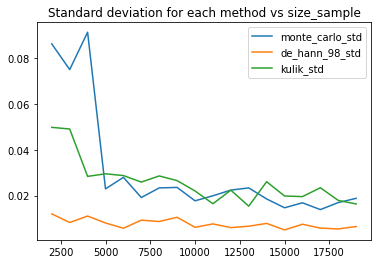

In [ ]:
size_samples = list(range(2_000,20_000,1_000))
plt.plot(size_samples, std_vs_size_dict["monte_carlo_std"], label="monte_carlo_std")
plt.plot(size_samples, std_vs_size_dict["de_hann_98_std"], label="de_hann_98_std")
plt.plot(size_samples, std_vs_size_dict["kulik_std"], label="kulik_std")
plt.title("Standard deviation for each method vs size_sample")
plt.legend()

In [ ]:
import json
sampleDict = { "name": "Emma", "rollNumber": 5 }
with open("student.json", "w") as write_file:
    json.dump(sampleDict, write_file)
    
with open('student.json', 'r') as fp:
    data = json.load(fp)

data

{'name': 'Emma', 'rollNumber': 5}

# De hann 2022

In [ ]:
def get_POT_estimator(sample):
    pass

In [ ]:
mult_hill_list = sorted(mult_hill_list)
mult_hill_list

NameError: name 'mult_hill_list' is not defined

In [ ]:
import numpy as np
s = np.random.poisson(1, 10000)

import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 14, density=True)
plt.show()

ModuleNotFoundError: No module named 'numpy'

In [ ]:
s[0]

NameError: name 's' is not defined

(array([ 3., 10.,  9., 16., 23., 12., 13.,  9.,  2.,  3.]),
 array([3.71960749, 3.73071831, 3.74182913, 3.75293995, 3.76405077,
        3.77516159, 3.78627241, 3.79738323, 3.80849406, 3.81960488,
        3.8307157 ]),
 <BarContainer object of 10 artists>)

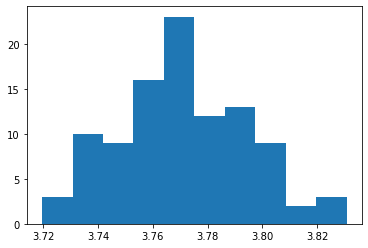

In [ ]:
plt.hist(hill_list)

In [ ]:
np.std(mult_hill_list)

0.0032718564792361027

In [ ]:
[len(l) for l in block_list]

[39,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,
 40,
 39,
 40,
 40,
 39,


In [ ]:
len(block_list)

504

In [ ]:
l = block_list[0]
l
sorted(l, reverse=True)

[4.826326816274365,
 3.670521545049102,
 2.87128727862766,
 2.552677781200944,
 1.9272388629941095,
 1.7065129690843446,
 1.5547228852118196,
 1.532804096894906,
 1.5170033182279585,
 1.4952798061271888,
 1.4389386639105033,
 1.4090484163283241,
 1.3463818800587244,
 1.3411593954856862,
 1.3218359900290662,
 1.2426422791706266,
 1.2388495970036073,
 1.1944433276355748,
 1.126820917566719,
 1.1014094023933145,
 1.0669826926186996,
 1.0384243592741413,
 1.0095423174786644,
 0.9874753462591376,
 0.9805395247288256,
 0.9611815568369804,
 0.9500195313993505,
 0.9440761108444427,
 0.910716607006575,
 0.8959014850442677,
 0.8916659665564628,
 0.8847164928581464,
 0.8625409355581685,
 0.8567427935568038,
 0.8279692659738143,
 0.7427862184733408,
 0.7349002399204609,
 0.7248110200388327,
 0.6853591720594644]

In [ ]:
l

array([1.00954232, 0.98747535, 1.06698269, 1.34638188, 1.49527981,
       1.1014094 , 0.82796927, 0.86254094, 1.32183599, 0.68535917,
       2.55267778, 0.85674279, 0.88471649, 2.87128728, 1.03842436,
       1.5328041 , 0.94407611, 0.89590149, 0.98053952, 0.89166597,
       1.40904842, 4.82632682, 1.19444333, 0.74278622, 0.91071661,
       1.70651297, 1.2388496 , 1.51700332, 1.3411594 , 1.55472289,
       3.67052155, 1.24264228, 0.72481102, 0.95001953, 1.12682092,
       1.92723886, 0.73490024, 1.43893866, 0.96118156])